In [95]:
import pandas as pd
from pandas.tseries.offsets import BDay
import numpy as np
import matplotlib.pyplot as plt
import psycopg2 as pg
from scipy import stats
from cmdstanpy import CmdStanModel
import arviz as az

from config import DATABASE_URI

plt.rcParams["figure.figsize"] = (15,10)

# Data

In [303]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT date, close FROM prices WHERE frequency='MINUTE' AND ticker='^GSPC'")
        result = cur.fetchall()
    
data = pd.DataFrame.from_records(result, columns=["date", "close"], coerce_float=True, index="date").squeeze()

# Daily realized volatility estimator from intraday data
results = {}
for idx, day in data.groupby(data.index.date):
    results[idx] = np.sum(np.square(np.log(day) - np.log(day.shift(1))))

vol = pd.Series(results)
vol = vol.reindex(pd.to_datetime(vol.index))
wk_vol = np.sqrt(vol.rolling(5).sum().dropna())
# Transform to annual percentage terms
wk_vol = wk_vol * np.sqrt(252/5) * 100
# Predicting log volatility is easier, so transform
wk_vol = np.log(wk_vol)

In [333]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT date, close FROM prices WHERE frequency='MINUTE' AND ticker='^GSPC'")
        result = cur.fetchall()
    
data = pd.DataFrame.from_records(result, columns=["date", "close"], coerce_float=True, index="date").squeeze()

results = {}
for idx, day in data.groupby(data.index.date):
    returns = np.log(day) - np.log(day.shift(1))
    abs_var = np.abs(returns) * np.abs(returns.shift(1))
    results[idx] = (np.pi/2) * np.sum(abs_var)

In [334]:
test = pd.Series(results)
test = test.reindex(pd.to_datetime(test.index))

In [317]:
with pg.connect(DATABASE_URI) as conn:
    with conn.cursor() as cur:
        cur.execute("SELECT ticker, date, close FROM prices WHERE frequency='DAILY' AND ticker IN ('^GSPC', '^VIX')")
        result = cur.fetchall()

data = pd.DataFrame.from_records(result, columns=["ticker", "date", "close"], coerce_float=True, index="date")
data = data.sort_index()

spx = data[data["ticker"] == "^GSPC"]["close"]
vix = data[data["ticker"] == "^VIX"]["close"]
# We are predicting log of volatility, so transform VIX to be same scale
vix = np.log(vix)

spx_wk_returns = (np.log(spx) - np.log(spx.shift(5))).dropna()

In [217]:
# Input features construction
x = pd.DataFrame(index=wk_vol.index)
# Realized volatility from last 4 weekly periods
x["RV-1"] = wk_vol
x["RV-2"] = wk_vol.shift(5)
x["RV-3"] = wk_vol.shift(10)
x["RV-4"] = wk_vol.shift(15)
# Last 4 end-of-week VIX values
x["VIX-1"] = vix
x["VIX-2"] = vix.shift(5)
x["VIX-3"] = vix.shift(10)
x["VIX-4"] = vix.shift(15)
# SPX returns from previous 4 weeks
x["SPX-1"] = spx_wk_returns
x["SPX-2"] = spx_wk_returns.shift(5)
x["SPX-3"] = spx_wk_returns.shift(10)
x["SPX-4"] = spx_wk_returns.shift(15)
# Standard deviation of RV over past month
x["RV-VOL"] = wk_vol.rolling(21).std()

# Calculates RV percentile rank.
# Percent of RV's in the last year that are below the last
# recorded RV value
rv_percentile = pd.Series(index=x.index, dtype=float)

for date in rv_percentile.index:
    # Get past year worth of RV data, if there isn't enough, skip
    wk_vol_interval = wk_vol.loc[date - BDay(252):date]
    if len(wk_vol_interval) < 240:
        continue
    rv_percent = stats.percentileofscore(wk_vol_interval, wk_vol.loc[date])
    rv_percentile.loc[date] = rv_percent
# 1-year RV rank
x["RV-PERCENT"] = rv_percentile

In [218]:
x = x.dropna()
# Forecasting objective: 1 week forward RV
y = wk_vol.shift(-5).dropna()

common_index = x.index.intersection(y.index)

split = int(0.80 * len(common_index))
x_train = x.loc[common_index[:split]]
y_train = y.loc[common_index[:split]]
x_test = x.loc[common_index[split:]]
y_test = y.loc[common_index[split:]]

# Model

In [276]:
model_spec = """
data {
    int N;  // Length of data
    int M;  // Number of features
    vector[N] y;  // Forecast objective
    matrix[N, M] x;  // Features matrix
}
parameters {
    real<lower=0> sigma;
    real<lower=0> rho;
    vector[M] beta;
}
model {
    sigma ~ normal(0, 10);
    rho ~ normal(0, 5);
    beta ~ normal(0, rho);
    y ~ normal(x * beta, sigma);
}
generated quantities {
    real y_tilde[N];  // Posterior predictive
    y_tilde = exp(normal_rng(x * beta, sigma));  // inverse log transform for volatility
}
"""

In [277]:
with open("./stan_model/RV_model.stan", "w") as file:
    file.write(model_spec)

model = CmdStanModel(stan_file="./stan_model/RV_model.stan")
data = {
    "N": len(x_train),
    "M": len(x_train.columns),
    "y": y_train.values,
    "x": x_train.values
}
sample = model.sample(data=data, chains=4, parallel_chains=4, iter_warmup=500, iter_sampling=2500)

INFO:cmdstanpy:compiling stan program, exe file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:compiler options: stanc_options=None, cpp_options=None
INFO:cmdstanpy:compiled model file: /home/eadains/VolatilityTrading/stan_model/RV_model
INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4
INFO:cmdstanpy:finish chain 3


In [278]:
# Inverse log transform on observed data
model_data = az.from_cmdstanpy(posterior=sample, posterior_predictive="y_tilde", observed_data={"y": np.exp(y_train.values)})

array([[<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'rho'}>,
        <AxesSubplot:title={'center':'rho'}>],
       [<AxesSubplot:title={'center':'beta'}>,
        <AxesSubplot:title={'center':'beta'}>]], dtype=object)

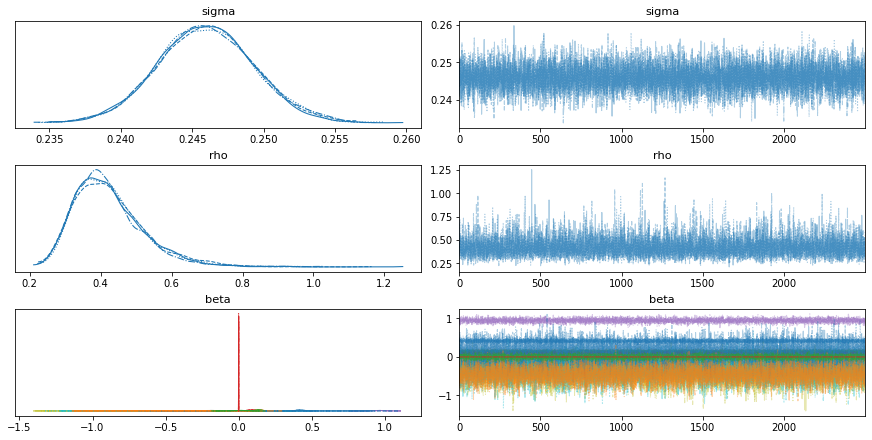

In [279]:
az.plot_trace(model_data, compact=True, var_names=["sigma", "rho", "beta"])

In [283]:
y_tilde = model_data.posterior_predictive.y_tilde.values.reshape(10000, -1)
mean = np.mean(y_tilde, axis=1)
std = np.std(y_tilde, axis=1)
skew = stats.skew(y_tilde, axis=1)
kurt = stats.kurtosis(y_tilde, axis=1)

Text(0.5, 1.0, 'Kurtosis')

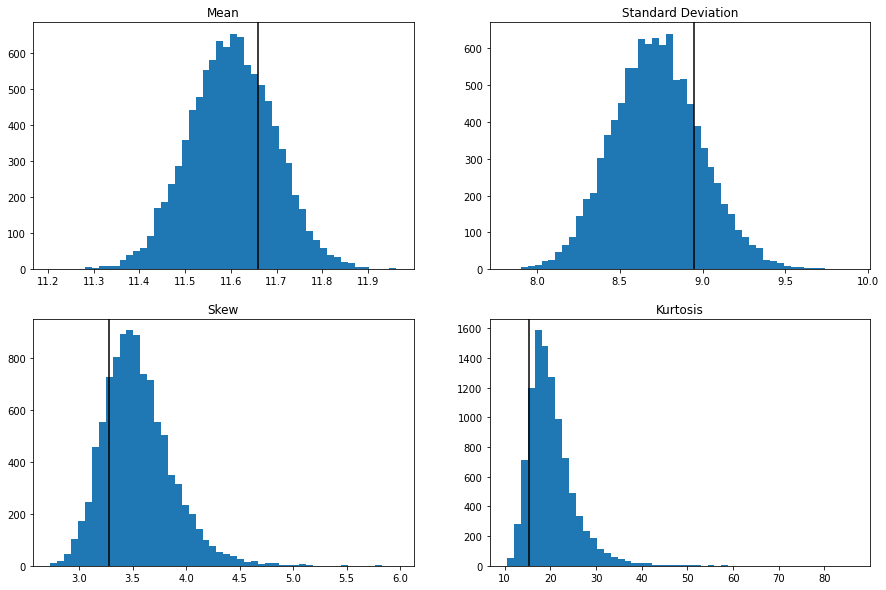

In [284]:
fig, axs = plt.subplots(2, 2)
axs[0, 0].hist(mean, bins=50)
axs[0, 0].axvline(np.mean(model_data.observed_data.y.values), color='black')
axs[0, 0].set_title("Mean")
axs[0, 1].hist(std, bins=50)
axs[0, 1].axvline(np.std(model_data.observed_data.y.values), color='black')
axs[0, 1].set_title("Standard Deviation")
axs[1, 0].hist(skew, bins=50)
axs[1, 0].axvline(stats.skew(model_data.observed_data.y.values), color='black')
axs[1, 0].set_title("Skew")
axs[1, 1].hist(kurt, bins=50)
axs[1, 1].axvline(stats.kurtosis(model_data.observed_data.y.values), color='black')
axs[1, 1].set_title("Kurtosis")

<AxesSubplot:xlabel='y / y_tilde'>

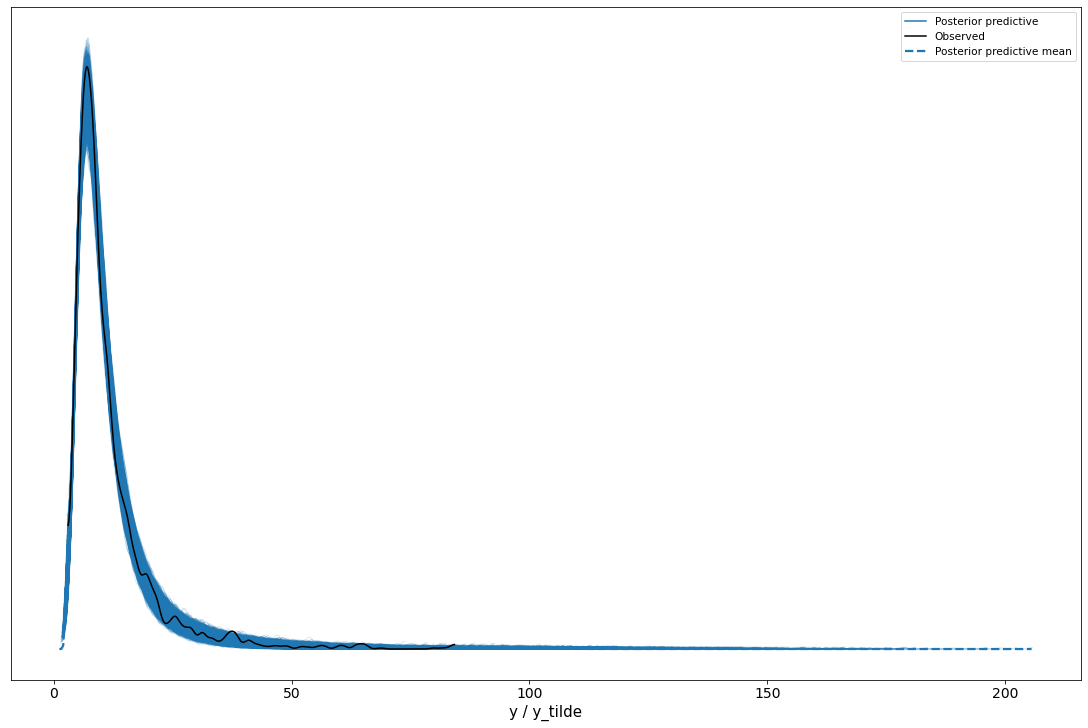

In [285]:
az.plot_ppc(model_data, data_pairs={"y": "y_tilde"})

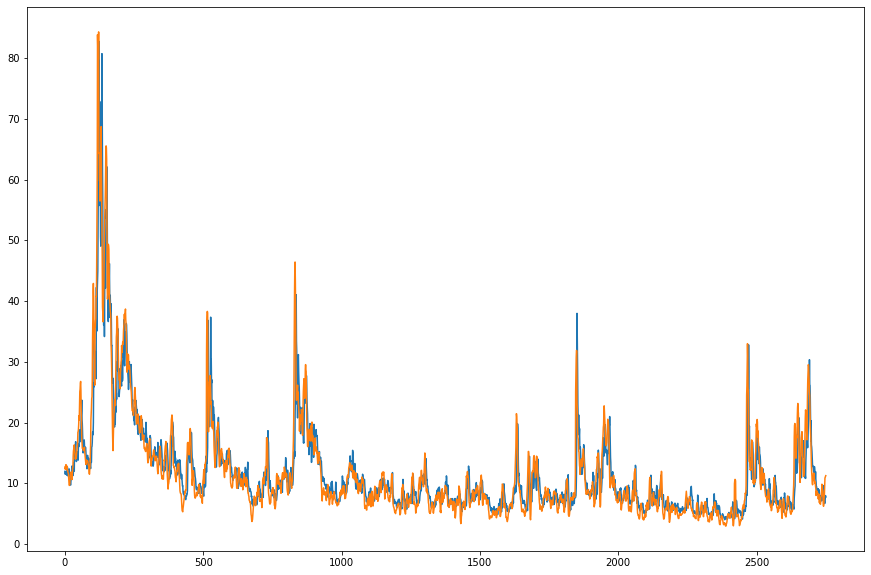

In [286]:
point_forecast = np.mean(y_tilde, axis=0)
plt.plot(point_forecast)
plt.plot(model_data.observed_data.y.values)

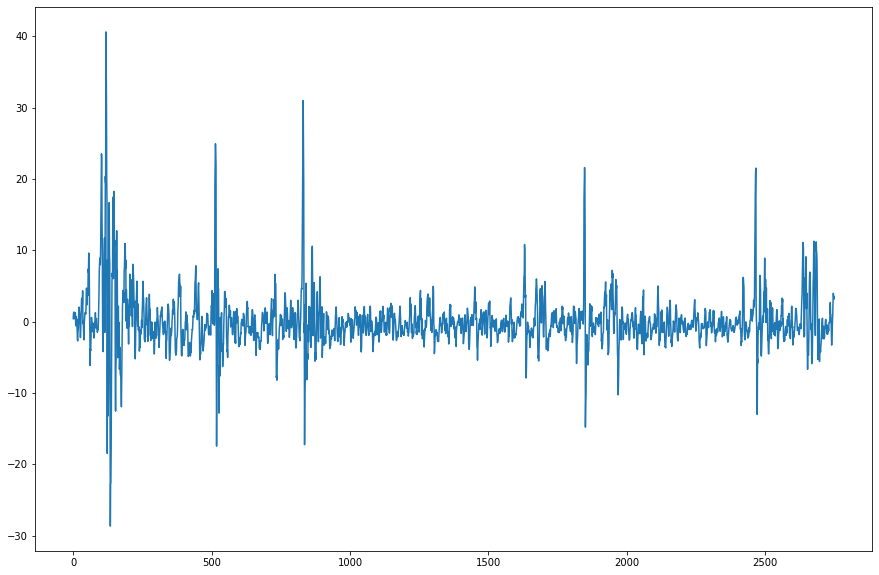

In [287]:
residuals = model_data.observed_data.y.values - point_forecast
plt.plot(residuals)

In [288]:
r2 = 1 - (np.sum(np.square(residuals)) / np.sum(np.square(model_data.observed_data.y.values - np.mean(model_data.observed_data.y.values))))
r2

0.8120525428023779

In [289]:
stats.skewtest(residuals)

SkewtestResult(statistic=31.28735448959085, pvalue=6.934404601887749e-215)

In [290]:
stats.kurtosistest(residuals)

KurtosistestResult(statistic=26.221821233846068, pvalue=1.4986462886311995e-151)